
# 上海二手房数据分析
## 一、根据上海的部分二手房信息，从多角度进行观察和分析房价与哪些因素有关以及房屋不同状况所占比例
## 二、先对数据进行预处理、构造预测房价的模型、并输入参数对房价进行预测
备注：数据来源CSDN下载。上海链家二手房.csv.因文件读入问题，改名为shanghai.csv

## 一、导入数据 对数据进行一些简单的预处理

In [1]:
#导入需要用到的包
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
sns.set_style({'font.sans-serif':['simhei','Arial']})
%matplotlib inline

In [2]:
shanghai=pd.read_csv('shanghai.csv')# 将已有数据导进来
shanghai.head(n=1)#显示第一行数据 查看数据是否导入成功


,house_title,house_img,s_cate_href,house_desc,zone_href,district,house_detail,house_price,house_href,s_cate,singel_price,house_time
0,卧室带阳台，卧室全南，地铁房，低区出入方便,http://cdn1.dooioo.com/fetch/vp/fy/gi/20170305...,http://sh.lianjia.com/ershoufang/quyang,1室0厅|37.6平|低区/6层|朝南,http://sh.lianjia.com/ershoufang/hongkou,虹口二手房,大二小区,250,http://sh.lianjia.com/ershoufang/sh4534309.html,曲阳,单价66489元/平,1985年建


### 每项数据类型均为object 不方便处理，需要对一些项删除单位转换为int或者float类型
### 有些列冗余 像house_img需要删除
### 有些列 如何house_desc包含多种信息 需要逐个提出来单独处理

In [3]:
shanghai.describe()

,house_price
count,73316.000000
mean,557.255415
std,563.623966
min,48.000000
25%,290.000000
50%,400.000000
75%,630.000000
max,35000.000000


In [4]:
# 检查缺失值情况
shanghai.info()
#np.isnan(shanghai).any()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73316 entries, 0 to 73315
Data columns (total 12 columns):
house_title     73314 non-null object
house_img       70428 non-null object
s_cate_href     73316 non-null object
house_desc      73316 non-null object
zone_href       73316 non-null object
district        73316 non-null object
house_detail    73316 non-null object
house_price     73316 non-null int64
house_href      73316 non-null object
s_cate          73316 non-null object
singel_price    73316 non-null object
house_time      70515 non-null object
dtypes: int64(1), object(11)
memory usage: 6.7+ MB


In [5]:
shanghai.dropna(inplace=True)
#数据处理 删除带有NAN项的行

In [6]:
df=shanghai.copy()
house_desc=df['house_desc']
house_desc[0]


'1室0厅|37.6平|低区/6层|朝南'

### house_desc 中带有 室厅的信息 房子面积 楼层 朝向信息 需要分别提出来当一列 下面进行提取

In [7]:
df['layout']=df['house_desc'].map(lambda x:x.split('|')[0])
df['area']=df['house_desc'].map(lambda x:x.split('|')[1])
df['temp']=df['house_desc'].map(lambda x:x.split('|')[2])
#df['Dirextion']=df['house_desc'].map(lambda x:x.split('|')[3])
df['floor']=df['temp'].map(lambda x:x.split('/')[0])
df.head(n=1)

,house_title,house_img,s_cate_href,house_desc,zone_href,district,house_detail,house_price,house_href,s_cate,singel_price,house_time,layout,area,temp,floor
0,卧室带阳台，卧室全南，地铁房，低区出入方便,http://cdn1.dooioo.com/fetch/vp/fy/gi/20170305...,http://sh.lianjia.com/ershoufang/quyang,1室0厅|37.6平|低区/6层|朝南,http://sh.lianjia.com/ershoufang/hongkou,虹口二手房,大二小区,250,http://sh.lianjia.com/ershoufang/sh4534309.html,曲阳,单价66489元/平,1985年建,1室0厅,37.6平,低区/6层,低区


### 一些列中带有单位 不利于后期处理 去掉单位 并把数据类型转换为float或int

In [8]:
df['area']=df['area'].apply(lambda x:x.rstrip('平'))
df['singel_price']=df['singel_price'].apply(lambda x:x.rstrip('元/平'))
df['singel_price']=df['singel_price'].apply(lambda x:x.lstrip('单价'))
df['district']=df['district'].apply(lambda x:x.rstrip('二手房'))
df['house_time']=df['house_time'].apply(lambda x:str(x))
df['house_time']=df['house_time'].apply(lambda x:x.rstrip('年建'))
df.head(n=1)


,house_title,house_img,s_cate_href,house_desc,zone_href,district,house_detail,house_price,house_href,s_cate,singel_price,house_time,layout,area,temp,floor
0,卧室带阳台，卧室全南，地铁房，低区出入方便,http://cdn1.dooioo.com/fetch/vp/fy/gi/20170305...,http://sh.lianjia.com/ershoufang/quyang,1室0厅|37.6平|低区/6层|朝南,http://sh.lianjia.com/ershoufang/hongkou,虹口,大二小区,250,http://sh.lianjia.com/ershoufang/sh4534309.html,曲阳,66489,1985,1室0厅,37.6,低区/6层,低区


### 删除一些不需要用到的列 以及 house_desc、temp

In [9]:
del df['house_img']
del df['s_cate_href']
del df['house_desc']
del df['zone_href']
del df['house_href']
del df['temp']


### 根据房子总价和房子面积 计算房子每平方米的价格
### 从house_title 描述房子信息中提取关键词。若带有 交通便利、地铁则认为其交通方便，否则交通不便

In [10]:
df.head(n=1)
df['singel_price']=df['singel_price'].apply(lambda x:float(x))
df['area']=df['area'].apply(lambda x:float(x))
df.head(n=1)
#df['trafic']=df['house_title'].apply(lambda x:'交通便利' if x.find("交通便利")>=0 or x.find("地铁")>=0 else "交通不便"  )
df.head(n=1)
df['house_title']=df['house_title'].apply(lambda x:str(x))
df['trafic']=df['house_title'].apply(lambda x:'交通便利' if x.find("交通便利")>=0 or x.find("地铁")>=0 else "交通不便"  )
df.head(n=1)



,house_title,district,house_detail,house_price,s_cate,singel_price,house_time,layout,area,floor,trafic
0,卧室带阳台，卧室全南，地铁房，低区出入方便,虹口,大二小区,250,曲阳,66489.0,1985,1室0厅,37.6,低区,交通便利


## 二、根据各列信息 用可视化的形式展现 房价与不同因素如地区、房子面积、所在楼层等之间的关系

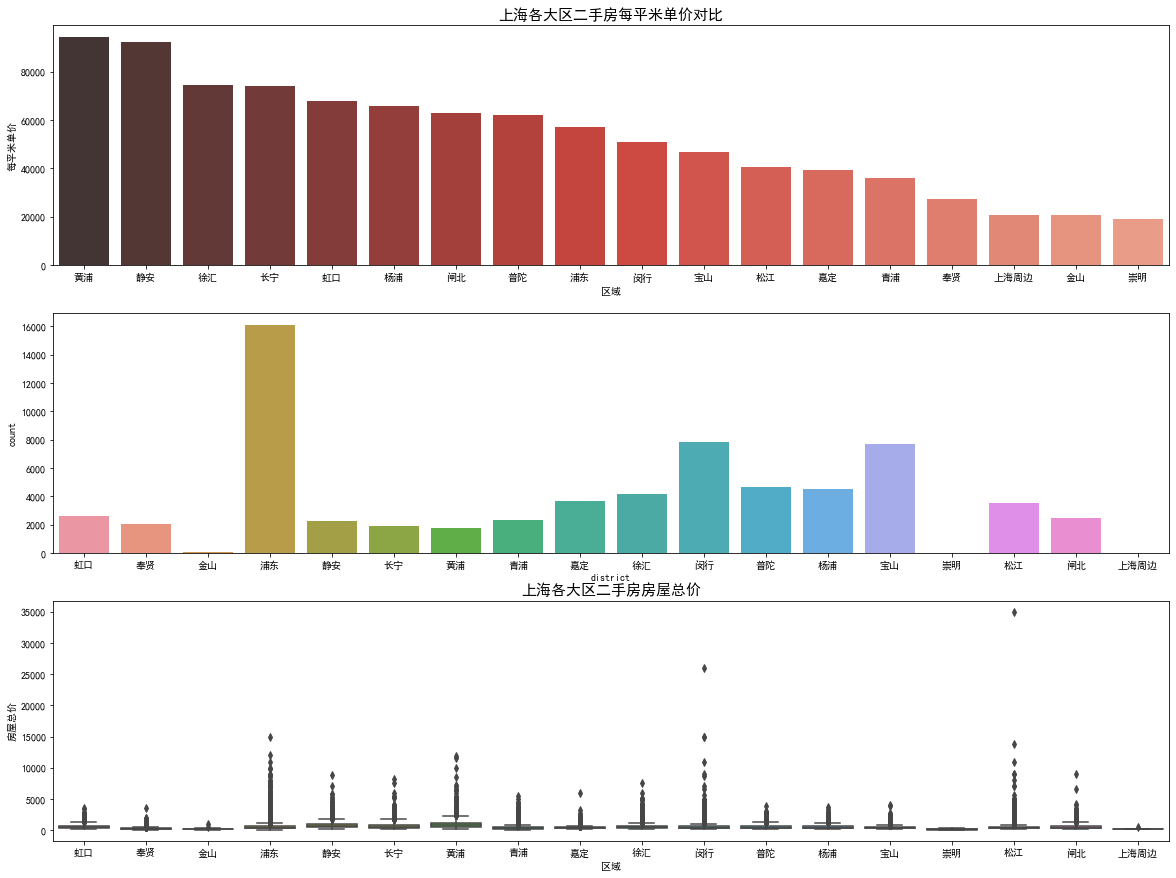

In [11]:
df_house_count = df.groupby('district')['house_price'].count().sort_values(ascending=False).to_frame().reset_index()
df_house_mean = df.groupby('district')['singel_price'].mean().sort_values(ascending=False).to_frame().reset_index()

f, [ax1,ax2,ax3] = plt.subplots(3,1,figsize=(20,15))
sns.barplot(x='district', y='singel_price', palette="Reds_d", data=df_house_mean, ax=ax1)
ax1.set_title('上海各大区二手房每平米单价对比',fontsize=15)
ax1.set_xlabel('区域')
ax1.set_ylabel('每平米单价')
sns.countplot(df['district'], ax=ax2)
sns.boxplot(x='district', y='house_price', data=df, ax=ax3)
ax3.set_title('上海各大区二手房房屋总价',fontsize=15)
ax3.set_xlabel('区域')
ax3.set_ylabel('房屋总价')
plt.show()



###  上面三幅图显示了 房子单价、总数量、总价与地区之间的关系。
#### 由上面第一幅图可以看到房子单价与地区有关，其中黄浦以及静安地区房价最高。这与地区的发展水平、交通便利程度以及离市中心远近程度有关
#### 由上面第二幅图可以直接看出不同地区的二手房数量，其中浦东最多
#### 由上面第三幅图可以看出上海二手房房价基本在一千万上下，很少有高于两千万的

In [12]:
df.loc[df['area']<10]
# 查看area样本

,house_title,district,house_detail,house_price,s_cate,singel_price,house_time,layout,area,floor,trafic


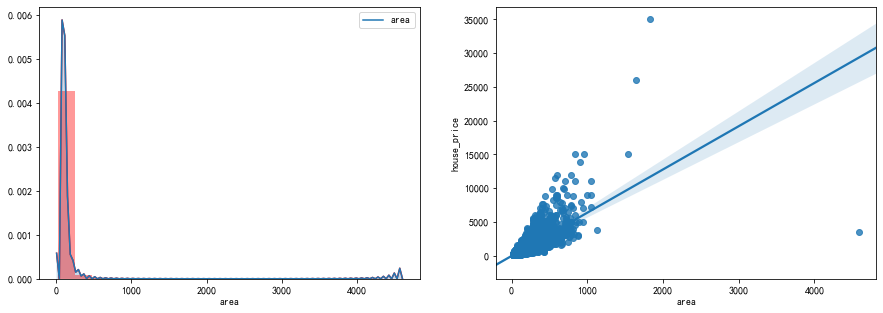

In [29]:
f, [ax1,ax2] = plt.subplots(1, 2, figsize=(15, 5))
# 二手房的面积分布
sns.distplot(df['area'], bins=20, ax=ax1, color='r')
sns.kdeplot(df['area'], shade=True, ax=ax1)
# 二手房面积和价位的关系
sns.regplot(x='area', y='house_price', data=df, ax=ax2)
plt.show()

### 由从左到右第一幅图可以看出 基本二手房面积在60-200平方米之间，其中一百平方米左右的占比更大
### 由第二幅看出，二手房总结与二手房面积基本成正比，和我们的常识吻合

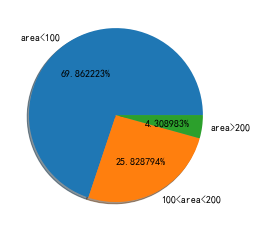

In [13]:
areas=[len(df[df.area<100]),len(df[(df.area>100)&(df.area<200)]),len(df[df.area>200])]
labels=['area<100' , '100<area<200','area>200']
plt.pie(areas,labels= labels,autopct='%0f%%',shadow=True)
plt.show()
# 绘制饼图

### 将面积划分为三个档次，面积大于200、面积小与100、面积在一百到两百之间 三者的占比情况可以发现 百分之六十九的房子面积在一百平方米一下，高于一百大于200的只有百分之二十五而面积大于两百的只有百分之四

In [14]:
df.loc[df['area']>1000]
# 查看size>1000的样本 发现只有一个是大于1000 

,house_title,district,house_detail,house_price,s_cate,singel_price,house_time,layout,area,floor,trafic
2704,洪中路138号，简单装修，高清实拍，链家好房,奉贤,洪中路138号,3500,奉城,7628.0,2003,6室3厅,4588.00,地上2层,交通不便
21867,绿城玫瑰园，上门实勘，链家真房源，链家好房,闵行,绿城玫瑰园,26000,马桥,158740.0,2014,6室4厅,1637.89,地上2层,交通不便
22894,品质装修，满五年，实地看房，上门实拍,闵行,绿城玫瑰园,15000,马桥,97816.0,2007,6室2厅,1533.48,地上2层,交通不便
35871,南北通，出行方便，拎包入住，满5年,松江,佘山高尔夫郡,9000,佘山,89982.0,2005,5室4厅,1000.20,地上2层地下1层,交通不便
37165,毛坯房，满五年，实地看房，上门实拍,松江,世茂佘山庄园,35000,佘山,191889.0,2008,6室3厅,1823.97,地上2层,交通不便
38986,世茂佘山庄园，毛坯房，房本满五年，高清实拍,松江,世茂佘山庄园,11000,佘山,104961.0,2007,5室3厅,1048.00,地上2层,交通不便
38993,世茂佘山庄园，满5年，热门带看，高清摄影,松江,世茂佘山庄园,9000,佘山,85714.0,2006,5室3厅,1050.00,地上4层,交通不便
40015,稀缺南北通，地铁直达，经典装修，满五减税,松江,佘山月湖山庄,3800,佘山,33765.0,2004,7室4厅,1125.40,地上2层,交通便利
70695,南北通，交通便利，低楼层，装修经典,浦东,浦东星河湾,7200,北蔡,69086.0,2010,8室3厅,1042.17,低区,交通便利


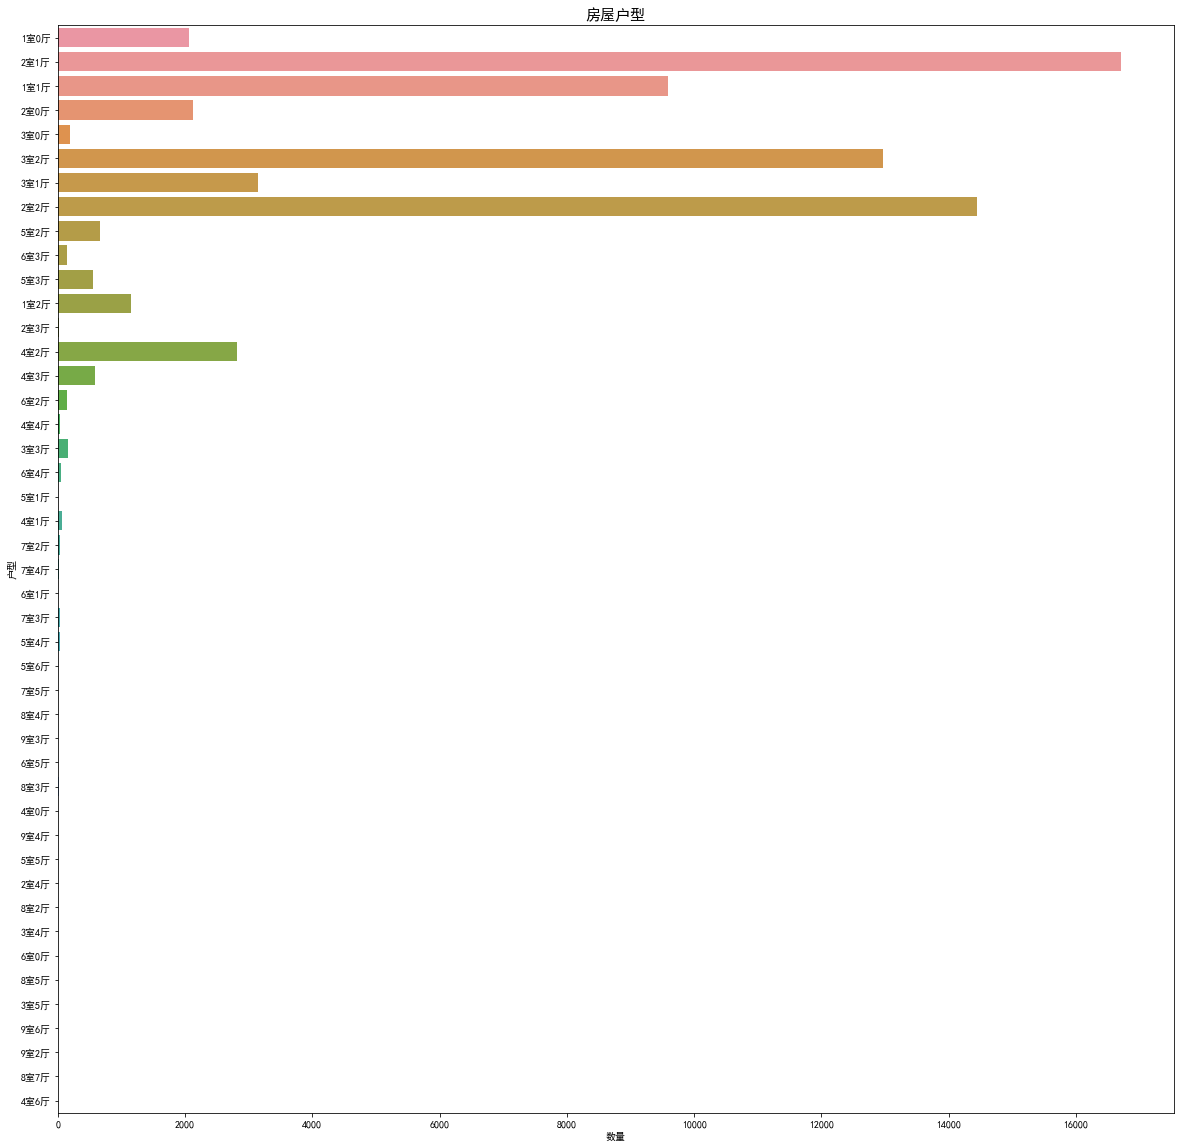

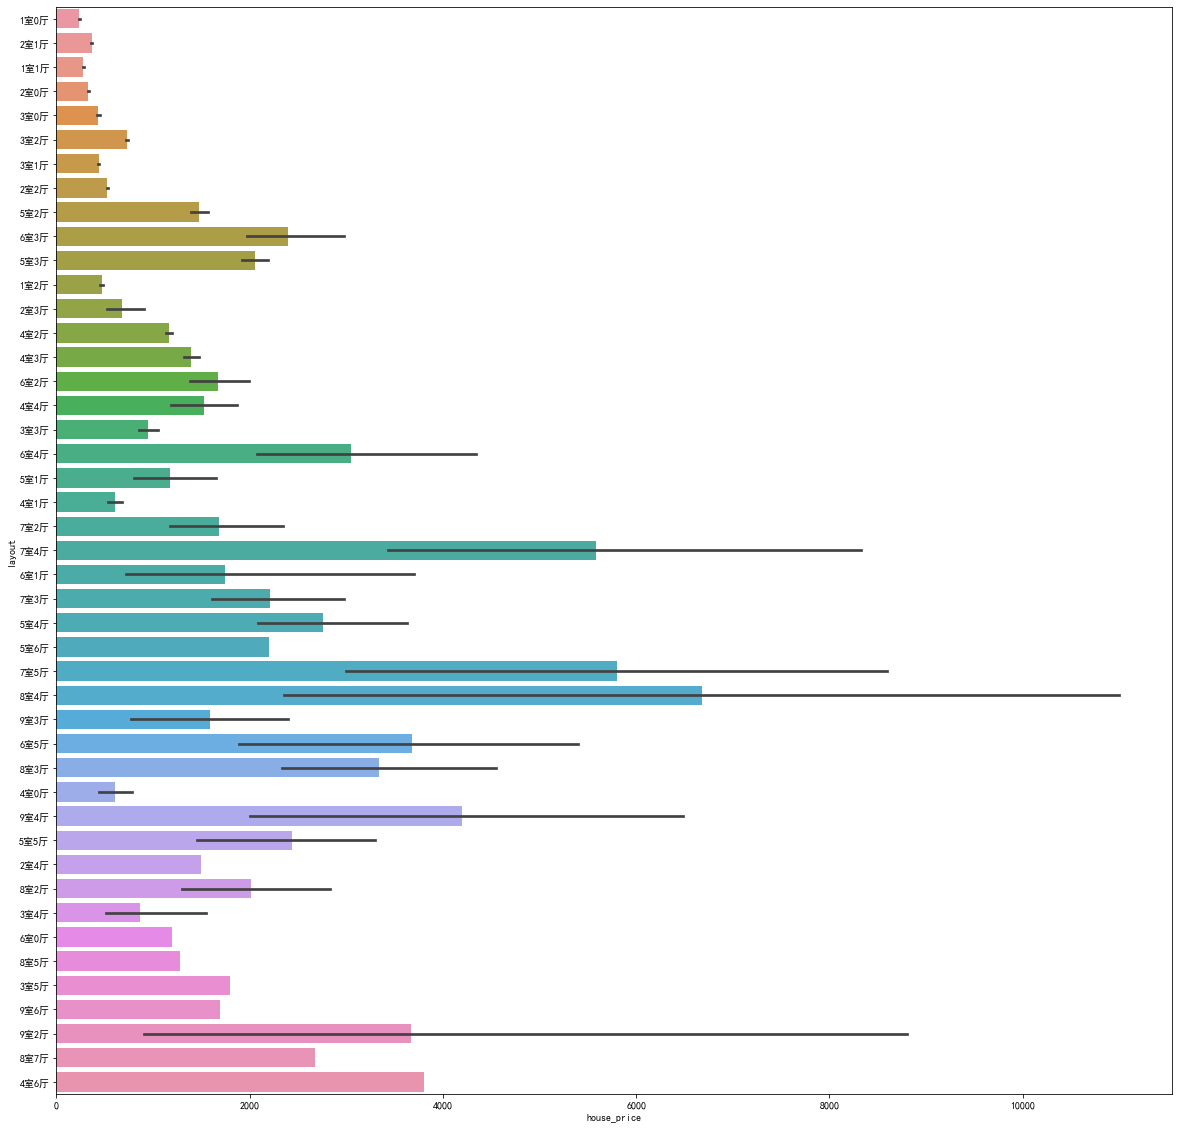

In [15]:
f, ax1= plt.subplots(figsize=(20,20))
sns.countplot(y='layout', data=df, ax=ax1)
ax1.set_title('房屋户型',fontsize=15)
ax1.set_xlabel('数量')
ax1.set_ylabel('户型')
f, ax2= plt.subplots(figsize=(20,20))
sns.barplot(y='layout', x='house_price', data=df, ax=ax2)
plt.show()

### 上述两幅图显示了 不同户型的数量和价格
#### 由第一幅图看出2室1厅最多 2室2厅 3室2厅也较多 是主流的户型选择 
#### 由第二幅看出 室和厅的数量增加随之价格也增加，但是室和厅之间的比例要适合

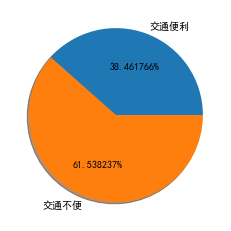

In [16]:
a1=0
a2=0
for x in df['trafic']:
    
    if x=='交通便利':
        a1=a1+1
    else:
        a2=a2+1
sizes=[a1,a2]
labels=['交通便利' , '交通不便']
plt.pie(sizes,labels= labels,autopct='%0f%%',shadow=True)
plt.show()

#### 上述图显示了上海二手房交通不便利情况。其中百分之六十一为交通不便，百分之三十八为交通不便。由于交通便利情况仅仅是根据对房屋的描述情况提取出来的，实际上 交通便利的占比会更高些

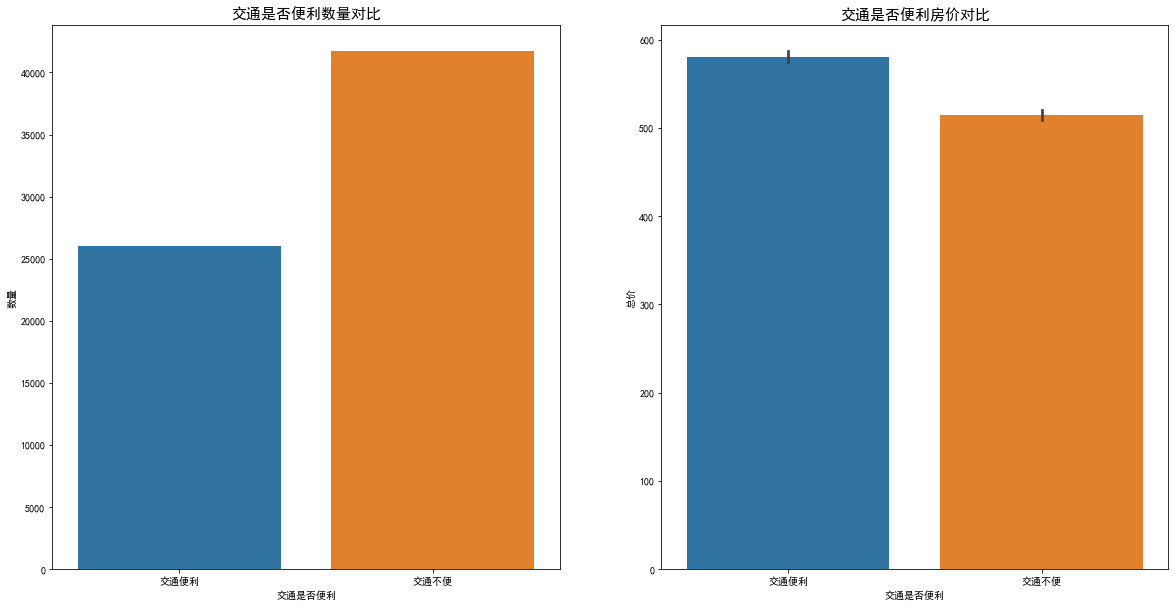

In [17]:
f, [ax1,ax2] = plt.subplots(1, 2, figsize=(20, 10))
sns.countplot(df['trafic'], ax=ax1)
ax1.set_title('交通是否便利数量对比',fontsize=15)
ax1.set_xlabel('交通是否便利')
ax1.set_ylabel('数量')
sns.barplot(x='trafic', y='house_price', data=df, ax=ax2)
ax2.set_title('交通是否便利房价对比',fontsize=15)
ax2.set_xlabel('交通是否便利')
ax2.set_ylabel('总价')

plt.show()


### 左边那幅图显示了交通便利以及不便的二手房数量，这与我们刚才的饼图信息一致
### 右边那幅图显示了交通便利与否与房价的关系。交通便利的房子价格更高

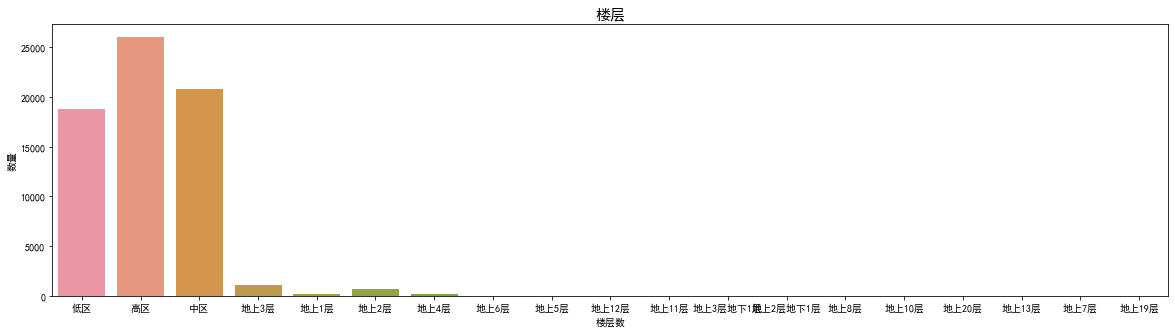

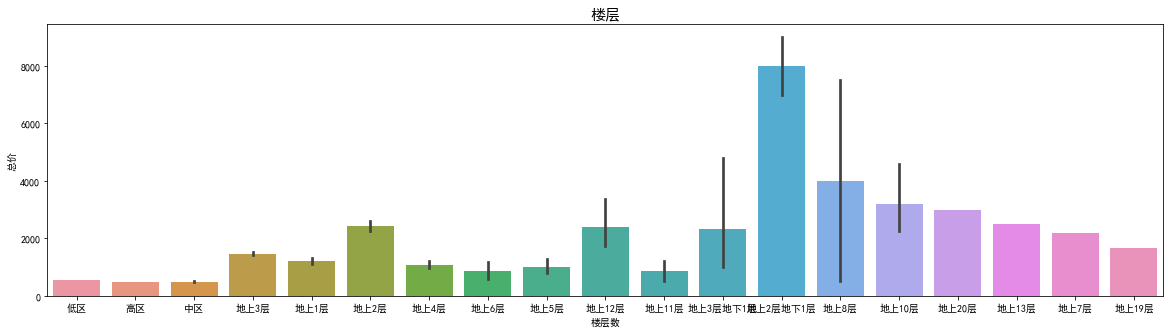

In [18]:
f, ax1= plt.subplots(figsize=(20,5))
sns.countplot(x='floor', data=df, ax=ax1)
ax1.set_title('楼层',fontsize=15)
ax1.set_xlabel('楼层数')
ax1.set_ylabel('数量')
f, ax2 = plt.subplots(figsize=(20, 5))
sns.barplot(x='floor', y='house_price', data=df, ax=ax2)
ax2.set_title('楼层',fontsize=15)
ax2.set_xlabel('楼层数')
ax2.set_ylabel('总价')
plt.show()

#### 楼层（地区、高区、中区、地下几层）与数量、房价的关系。高区、中区、低区居多

## 三、根据已有数据建立简单的上海二手房房间预测模型

### 对数据再次进行简单的预处理 把户型这列拆成室和厅

In [19]:
df[['室','厅']] = df['layout'].str.extract(r'(\d+)室(\d+)厅')
df['室'] = df['室'].astype(float)
df['厅'] = df['厅'].astype(float)
#data['卫'] = data['卫'].astype(float)
del df['layout']
df.head()

C:\Users\shuifan\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


,house_title,district,house_detail,house_price,s_cate,singel_price,house_time,area,floor,trafic,室,厅
0,卧室带阳台，卧室全南，地铁房，低区出入方便,虹口,大二小区,250,曲阳,66489.0,1985,37.60,低区,交通便利,1.0,0.0
1,厨卫全明，卧室带阳台，交通方便，采光好,虹口,西南小区,360,曲阳,69916.0,1982,51.49,高区,交通不便,2.0,1.0
2,卧室带阳台，卧室全南，交通方便，高区景观好,虹口,西南小区,345,曲阳,77720.0,1982,44.39,高区,交通不便,2.0,1.0
3,厨卫全明，卧室带阳台，地铁房，上下楼方便,虹口,曲一花苑,445,曲阳,78358.0,1983,56.79,低区,交通便利,2.0,1.0
4,稀罕南北通，地铁沿线，采光无遮挡，拎包入住,虹口,东体小区,320,曲阳,76812.0,1983,41.66,高区,交通便利,2.0,1.0


In [20]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67753 entries, 0 to 73304
Data columns (total 12 columns):
house_title     67753 non-null object
district        67753 non-null object
house_detail    67753 non-null object
house_price     67753 non-null int64
s_cate          67753 non-null object
singel_price    67753 non-null float64
house_time      67753 non-null object
area            67753 non-null float64
floor           67753 non-null object
trafic          67753 non-null object
室               67753 non-null float64
厅               67753 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 6.7+ MB


In [21]:
df.columns

Index(['house_title', 'district', 'house_detail', 'house_price', 's_cate',
       'singel_price', 'house_time', 'area', 'floor', 'trafic', '室', '厅'],
      dtype='object')

### 删除不需要用到的信息如房子的基本信息描述 

In [22]:
del df['house_title']
del df['house_detail']
del df['s_cate']


In [23]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
area=df['area']
price=df['house_price']
area = np.array(area).reshape(-1,1) # 这里需要注意新版的sklearn需要将数据转换为矩阵才能进行计算
price = np.array(price).reshape(-1,1)
# 训练模型
model = linear.fit(area,price)
# 打印截距和回归系数

print(model.intercept_, model.coef_)

[-61.47368693] [[6.41045431]]


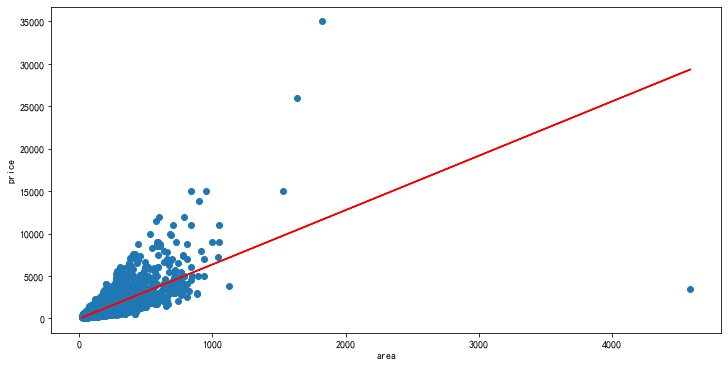

In [24]:
linear_p = model.predict(area)
plt.figure(figsize=(12,6))
plt.scatter(area,price)
plt.plot(area,linear_p,'red')
plt.xlabel("area")
plt.ylabel("price")
plt.show()

#### 上面用线性回归模型对房价进行简单的预测 红色的代表预测房价，而蓝色点代表真实值。可以看出在面积小于1000时真实值紧密分布在预测值两旁

In [ ]:
#### 在训练模型时对str的处理不方便。因此将18个地区分别用0-17个数字表示。用 1 表示 交通便利 用 0 表示交通不便。另外将成立房子建立年份转换为floata类型.

In [25]:
d=['宝山','奉贤','虹口','黄浦','嘉定','静安','闵行','浦东',
  '普陀','青浦','松江','徐汇','杨浦','闸北','长宁','金山','崇明','上海周边']
df['district']=df['district'].apply(lambda x:d.index(x))
df['house_time']=df['house_time'].apply(lambda x:float(x))
df['trafic']=df['trafic'].apply(lambda x:int(1) if x=='交通便利' else int(0))


In [26]:

#df.drop([len(df)-1],inplace=True)
cols=['house_time','area','室','厅','trafic','district']
X=df[cols]
X.head(n=2)

,house_time,area,室,厅,trafic,district
0,1985.0,37.60,1.0,0.0,1,2
1,1982.0,51.49,2.0,1.0,0,2


In [30]:
Y=df['house_price']
Y.head(n=2)

0    250
1    360
Name: house_price, dtype: int64

#### 使用了scikit-learn和线性回归算法做一个房价预测模型。房价特征有6个。分别使用一阶多项式线性回归，二阶多项式线性回归，和三阶多项式线性回归生成模型并作了性能比较。

In [31]:
from sklearn.model_selection import train_test_split
##将数据分为训练集和测试集,分20%作为测试集
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=3)
#训练模型
import time 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

result=['一阶多项式拟合结果','二阶多项式拟合结果','多项式拟合结果']
Train_score=[]
Cv_score=[]
#定义多项式模型函数
def polynomial_model(degree=1):
    polynomial_features=PolynomialFeatures(degree=degree,include_bias=False)
    linear_regression=LinearRegression(normalize=True)  #归一化数据进行训练，克加快算法收敛速度
    pipeline=Pipeline([("polynomial_feature",polynomial_features),("linear_regression",linear_regression)])
    return pipeline

model=polynomial_model(degree=1)  #使用二阶多项式模型拟合

start=time.clock()
model.fit(X_train,Y_train)

#模型预测与评估
train_score=model.score(X_train,Y_train)
cv_score=model.score(X_test,Y_test)
print('使用一阶多项式拟合结果')
print('elaspe:{0:.6f};train_score:{1:0.6f};cv_score:{2:.6f}'.format(time.clock()-start,train_score,cv_score))
Train_score.append(train_score)
Cv_score.append(cv_score)

使用一阶多项式拟合结果
elaspe:0.039540;train_score:0.622180;cv_score:0.690372


In [32]:
model=polynomial_model(degree=2)  #使用二阶多项式模型拟合

start=time.clock()
model.fit(X_train,Y_train)

#模型预测与评估
train_score=model.score(X_train,Y_train)
cv_score=model.score(X_test,Y_test)
print('使用二阶多项式拟合结果')
print('elaspe:{0:.6f};train_score:{1:0.6f};cv_score:{2:.6f}'.format(time.clock()-start,train_score,cv_score))
Train_score.append(train_score)
Cv_score.append(cv_score)

使用二阶多项式拟合结果
elaspe:0.207715;train_score:0.687070;cv_score:0.719131


In [33]:
model=polynomial_model(degree=3)  #使用二阶多项式模型拟合

start=time.clock()
model.fit(X_train,Y_train)

#模型预测与评估
train_score=model.score(X_train,Y_train)
cv_score=model.score(X_test,Y_test)
print('使用阶多项式拟合结果')
print('elaspe:{0:.6f};train_score:{1:0.6f};cv_score:{2:.6f}'.format(time.clock()-start,train_score,cv_score))
Train_score.append(train_score)
Cv_score.append(cv_score)

使用阶多项式拟合结果
elaspe:0.967086;train_score:0.754008;cv_score:0.698847


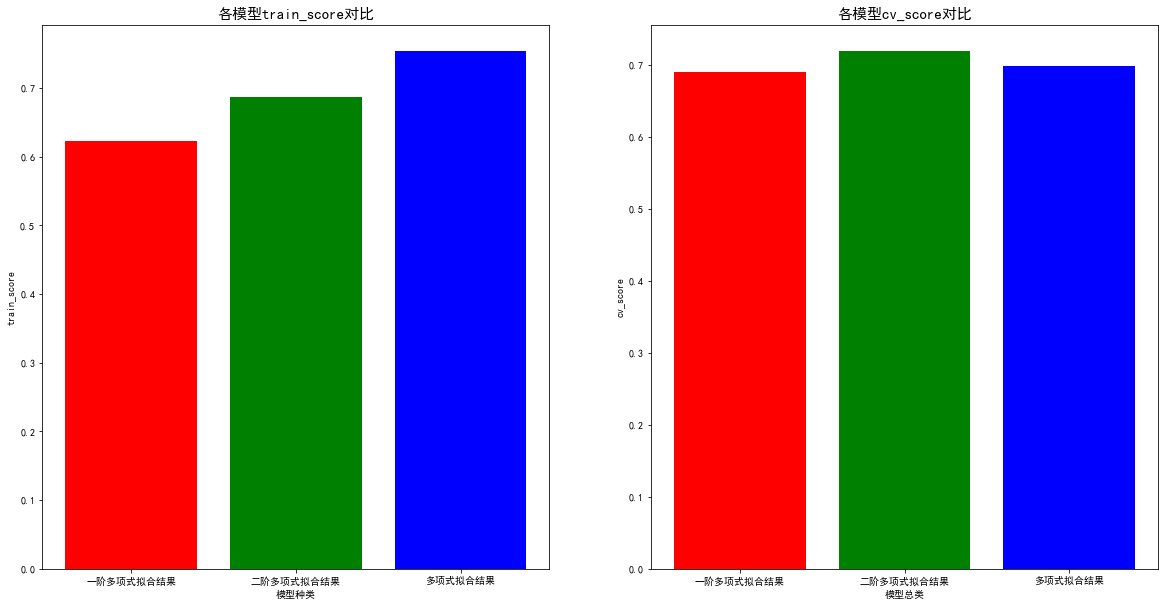

In [34]:
#Train_score
#Cv_score
result=np.array(result)
Train_score=np.array(Train_score)
Cv_score=np.array(Cv_score)
f, [ax1,ax2] = plt.subplots(1, 2, figsize=(20, 10))
#ax1.bar(Train_score,result)
ax1.bar(range(len(Train_score)), Train_score,color='rgb',tick_label=result)  
ax1.set_title('各模型train_score对比',fontsize=15)
ax1.set_xlabel('模型种类')
ax1.set_ylabel('train_score')
ax2.bar(range(len(Cv_score)),Cv_score,color='rgb',tick_label=result)        
ax2.set_title('各模型cv_score对比',fontsize=15)
ax2.set_xlabel('模型总类')
ax2.set_ylabel('cv_score')

plt.show()

#### 由上图可以看出 随着阶次上升模型训练集准确率显著上升，测试集准确率缓慢上升

In [37]:
#定义学习曲线函数
from sklearn.model_selection import learning_curve
import numpy as np

def plot_learning_curve(plt, estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : 训练集的特征
        array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : 训练集的标签
        array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : 交叉验证结果
        int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.title(title)   #画出标题
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")  #横轴标签
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)  #均值
    train_scores_std = np.std(train_scores, axis=1)    #方差
    test_scores_mean = np.mean(test_scores, axis=1)   
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")                #红色区域是准确性平均值的方差空间
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o--', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


elaspe:3.023455
elaspe:9.542797
elaspe:37.255698


<Figure size 3600x800 with 0 Axes>

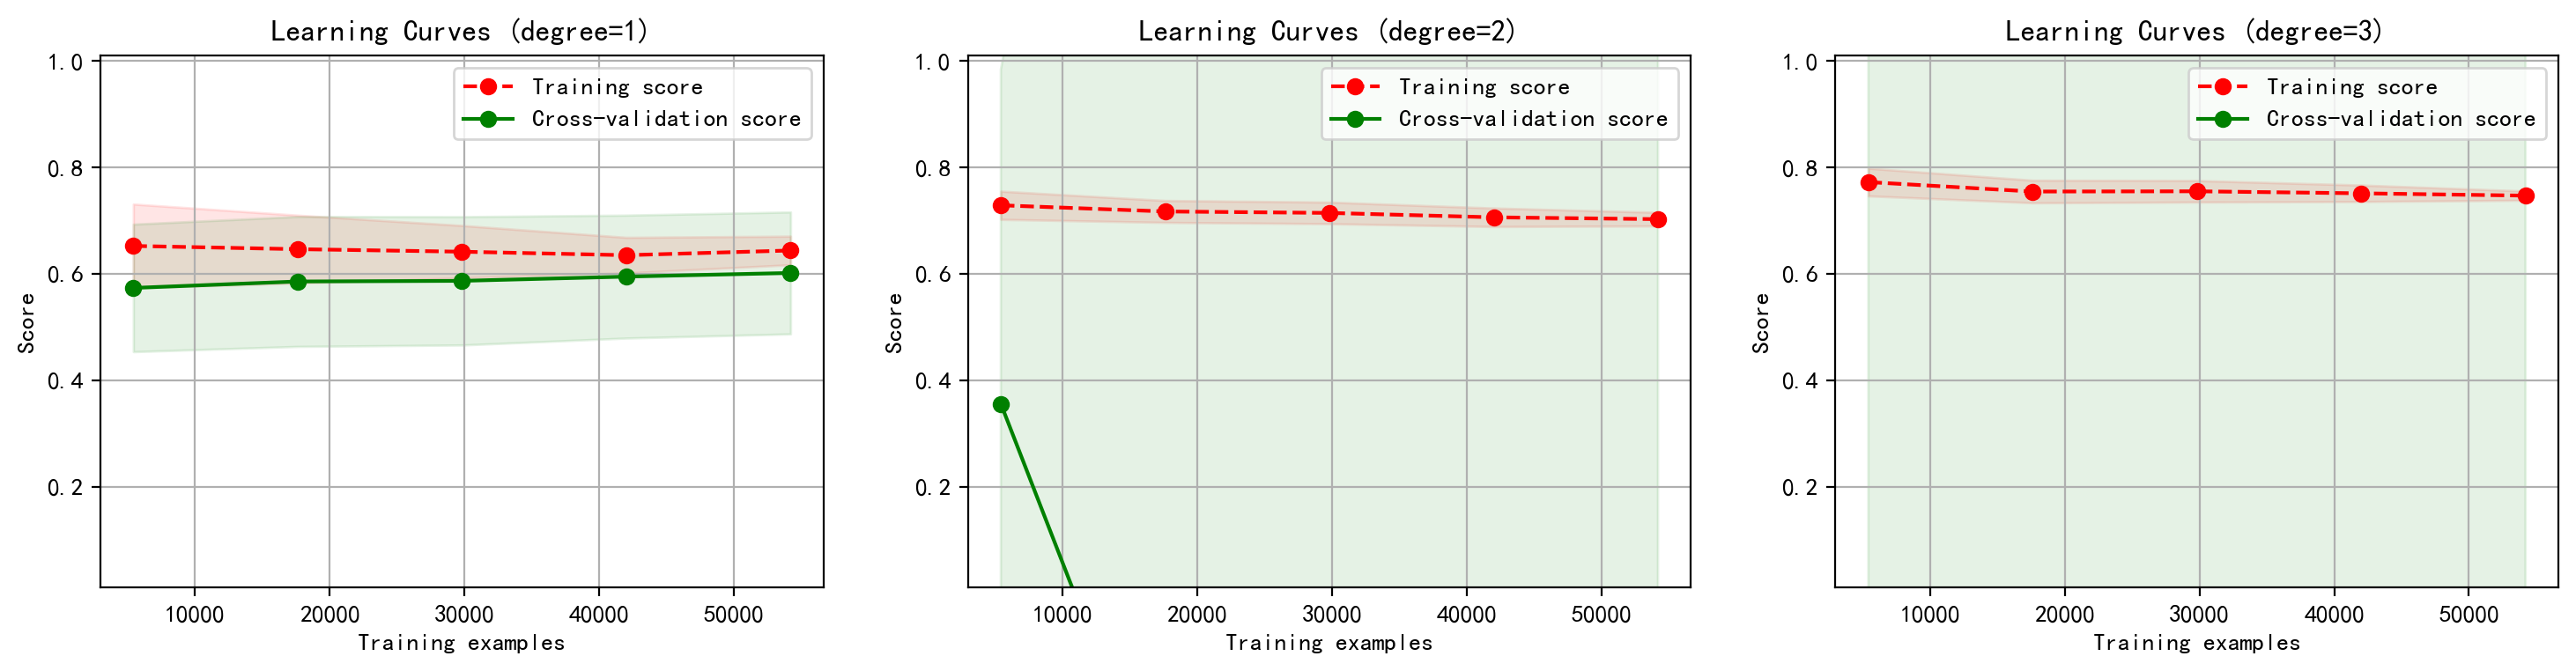

In [38]:
#画出学习曲线
from sklearn.model_selection import ShuffleSplit

cv=ShuffleSplit(n_splits=10,test_size=0.2,random_state=0)
plt.figure(figsize=(18,4),dpi=200)
title='Learning Curves (degree={0})' 
degrees=[1,2,3]

start=time.clock()
plt.figure(figsize=(18,4),dpi=200)
for i in range(len(degrees)):
    plt.subplot(1,3,i+1)
    plot_learning_curve(plt,polynomial_model(degrees[i]),title.format(degrees[i]),X,Y,ylim=(0.01,1.01),cv=cv)
    print('elaspe:{0:.6f}'.format(time.clock()-start))

### 图一 随着样本的增加，validation score和training score都在一个比较低的水平，则此时为欠拟合，再增加样本也无法增加模型的score。此时整个模型没有很好的抓住数据的特征。
### 图二 在最大样本数量的地方，training score比validation score大很多，属于过拟合。使用了过多特征
### 图三 模型偏差较大。
#### 综上上述三个模型都有点欠缺，整体不是很好。